In [58]:
# !pip3 install matplotlib
# !pip3 install tabula-py
# !pip3 install PyPDF2
# !pip3 install pdfminer.six
# !pip3 install PyMuPDF
# !pip3 install camelot-py
# !pip3 install --upgrade pip
# !pip3 install geopandas
# !pip3 install plotly

In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import os
import PyPDF2
import tabula
import tabulate
import pdfminer
import geopandas as gpd
import fiona
from glob import glob
import plotly.express as px
from shapely.geometry import Point


In [60]:
# data_path = input("include relative path to the dataset: (should work for windows/mac: )")
data_path = os.getcwd()+"/Data Sets/CT_GTFS/stops.txt"
# with open(data_path, 'r') as f:
#     print(f.read())

shape = pd.read_csv(data_path)
shape_geo = gpd.GeoDataFrame(shape)


In [61]:
shape_geo.shape
shape_geo.columns
shape_geo['coordinates'] = shape_geo.apply(lambda row: Point(row['stop_lat'], row['stop_lon']), axis=1)

# shape_geo.set_geometry(col=['shape_pt_lat','shape_pt_lon'])
# shape_geo.get_coordinates()

In [62]:
shape_geo.head()
stop_geo = gpd.GeoDataFrame(shape_geo, geometry='coordinates')

(6279, 10)
coordinates


<Axes: >

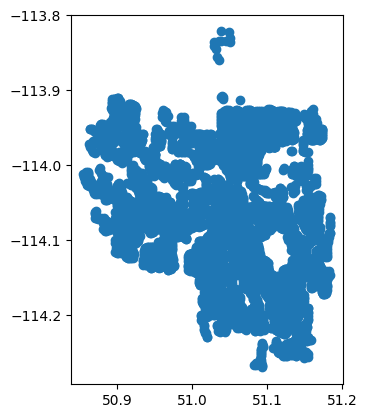

In [63]:
print(stop_geo.shape)
print(stop_geo.geometry.name)
stop_geo.plot()

In [64]:
community_path = os.getcwd() + "/Community Profiles/"
ward_path = os.getcwd() + "/ward_profiles/"

if os.path.isdir(ward_path):
    try:
        # List all files in the specified folder
        files = os.listdir(ward_path)

        # Extract file names
        file_names = [file for file in files if os.path.isfile(os.path.join(ward_path, file)) and "ward" in file]

        # print("File names in the folder:")
        # for file_name in file_names:
        #     print(file_name)

    except FileNotFoundError:
        print(f"The specified folder '{folder_path}' does not exist.")
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")

# data = camelot.read_pdf(ward_path+file_names[0])

In [65]:
data = tabula.read_pdf(ward_path+file_names[0], pages = [2,14,16,22], multiple_tables =True)

Error importing jpype dependencies. Fallback to subprocess.
No module named 'jpype'


In [71]:
for i in data:
    print(tabulate.tabulate(i))
    # print(type(i))

-  -----------------------  --------  ------------------------  --------
0  Number                   Per cent  Number                    Per cent
1  Population in private    nan       Population in private     nan
2  98,175                   100%      1,291,790                 100%
3  households               nan       households                nan
4  0 to 14 years 18,750     19%       0 to 14 years 235,540     18%
5  15 to 64 years 65,395    67%       15 to 64 years 888,985    69%
6  65 to 84 years 12,675    13%       65 to 84 years 152,425    12%
7  85 years and over 1,360  1%        85 years and over 14,845  1%
-  -----------------------  --------  ------------------------  --------
--  -------------  -------------  -------  -------------  -----------------  -------
 0  nan            Total Men +    Women +  nan            Total Men +        Women +
 1  Population in  nan            nan      Population in  nan                nan
 2  private        98,175 47,660  50,515   private    